In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import gzip
import pyranges as pr

#### Load tree index/ID info

In [2]:
trees = pd.read_csv("numbered_10kbtreepaths.txt", sep="\t", index_col=0, header=None)

In [3]:
trees.columns = ["window_id"]

In [4]:
trees["chromosome"] = trees["window_id"].replace(".fa.tree", "", regex=True)

In [5]:
trees["chromosome"] = [s.split("_")[0] for s in trees.window_id]
trees["start"] = [s.replace(".fa.tree", "").split("_bp_")[1].split("-")[0] for s in trees.window_id]
trees["end"] = [s.replace(".fa.tree", "").split("_bp_")[1].split("-")[1] for s in trees.window_id]

In [6]:
trees

,window_id,chromosome,start,end
0,,,,
1,LG01_bp_10000001-10010000.fa.tree,LG01,10000001,10010000
2,LG01_bp_1000001-1010000.fa.tree,LG01,1000001,1010000
3,LG01_bp_100001-110000.fa.tree,LG01,100001,110000
4,LG01_bp_10001-20000.fa.tree,LG01,10001,20000
5,LG01_bp_10010001-10020000.fa.tree,LG01,10010001,10020000
...,...,...,...,...
25855,LG09_bp_60001-70000.fa.tree,LG09,60001,70000
25856,LG09_bp_70001-80000.fa.tree,LG09,70001,80000
25857,LG09_bp_90001-100000.fa.tree,LG09,90001,100000


#### Load data and merge with the tree ID info

In [7]:
laevis_eatonii_barbatus = pd.read_csv("laevis_eatonii_barbatus.weights.txt.gz", compression="gzip", index_col=None, comment="#", sep ="\t")
virgatus_barbatus_eatonii = pd.read_csv("virgatus_barbatus_eatonii.weights.txt.gz", compression="gzip", index_col=None, comment="#", sep ="\t")

In [8]:
laevis_eatonii_barbatus.index = laevis_eatonii_barbatus.index + 1 
virgatus_barbatus_eatonii.index = virgatus_barbatus_eatonii.index + 1 

In [9]:
laevis_eatonii_barbatus = pd.concat([laevis_eatonii_barbatus, trees], axis=1)
virgatus_barbatus_eatonii = pd.concat([virgatus_barbatus_eatonii, trees], axis=1)

In [10]:
laevis_eatonii_barbatus["trio"] = ["laevis_eatonii_barbatus" for i in range(len(laevis_eatonii_barbatus.index))]
virgatus_barbatus_eatonii["trio"] = ["virgatus_barbatus_eatonii" for i in range(len(virgatus_barbatus_eatonii.index))]

In [11]:
combined_df = pd.concat([laevis_eatonii_barbatus, virgatus_barbatus_eatonii])

In [12]:
combined_df["tree_no"] = combined_df.index

In [13]:
t1_norm = combined_df["topo1"]/(combined_df["topo1"]+combined_df["topo2"]+combined_df["topo3"])
t2_norm = combined_df["topo2"]/(combined_df["topo1"]+combined_df["topo2"]+combined_df["topo3"])
t3_norm = combined_df["topo3"]/(combined_df["topo1"]+combined_df["topo2"]+combined_df["topo3"])

In [14]:
combined_df["topo1"] = t1_norm
combined_df["topo2"] = t2_norm
combined_df["topo3"] = t3_norm

In [15]:
combined_df["t3t2_diff"] = combined_df["topo3"]- combined_df["topo2"]

In [16]:
combined_df

,topo1,topo2,topo3,window_id,chromosome,start,end,trio,tree_no,t3t2_diff
1,1.00,0.00,0.00,LG01_bp_10000001-10010000.fa.tree,LG01,10000001,10010000,laevis_eatonii_barbatus,1,0.0
2,1.00,0.00,0.00,LG01_bp_1000001-1010000.fa.tree,LG01,1000001,1010000,laevis_eatonii_barbatus,2,0.0
3,1.00,0.00,0.00,LG01_bp_100001-110000.fa.tree,LG01,100001,110000,laevis_eatonii_barbatus,3,0.0
4,1.00,0.00,0.00,LG01_bp_10001-20000.fa.tree,LG01,10001,20000,laevis_eatonii_barbatus,4,0.0
5,1.00,0.00,0.00,LG01_bp_10010001-10020000.fa.tree,LG01,10010001,10020000,laevis_eatonii_barbatus,5,0.0
...,...,...,...,...,...,...,...,...,...,...
25855,1.00,0.00,0.00,LG09_bp_60001-70000.fa.tree,LG09,60001,70000,virgatus_barbatus_eatonii,25855,0.0
25856,1.00,0.00,0.00,LG09_bp_70001-80000.fa.tree,LG09,70001,80000,virgatus_barbatus_eatonii,25856,0.0
25857,0.00,0.90,0.10,LG09_bp_90001-100000.fa.tree,LG09,90001,100000,virgatus_barbatus_eatonii,25857,-0.8
25858,0.68,0.16,0.16,LG10_bp_30001-31112.fa.tree,LG10,30001,31112,virgatus_barbatus_eatonii,25858,0.0


#### Plot the topology weights

##### Display the topologies

In [17]:
laevis_eatonii_barbatus_topos = {}
with gzip.open("laevis_eatonii_barbatus.weights.txt.gz", "rt") as fin:
    for line in fin:
        if "#" in line:
            #print(line.split())
            t = line.split()[0]
            tr = line.split()[1]
            laevis_eatonii_barbatus_topos[t] = tr
            
laevis_eatonii_barbatus_topos

{'#topo1': '(palmeri,((laevis,eatonii),barbatus));',
 '#topo2': '(palmeri,((laevis,barbatus),eatonii));',
 '#topo3': '(palmeri,(laevis,(eatonii,barbatus)));'}

In [18]:
virgatus_barbatus_eatonii_topos={}
with gzip.open("virgatus_barbatus_eatonii.weights.txt.gz", "rt") as fin:
    for line in fin:
        if "#" in line:
            #print(line.split())
            t = line.split()[0]
            tr = line.split()[1]
            virgatus_barbatus_eatonii_topos[t] = tr
            
virgatus_barbatus_eatonii_topos

{'#topo1': '(palmeri,((virgatus,barbatus),eatonii));',
 '#topo2': '(palmeri,((virgatus,eatonii),barbatus));',
 '#topo3': '(palmeri,(virgatus,(barbatus,eatonii)));'}

##### Plot distributions of normalized topology weights

In [19]:
combined_df[["topo1", "topo2", "topo3", "t3t2_diff"]].mean()

topo1        0.804219
topo2        0.103652
topo3        0.092129
t3t2_diff   -0.011523
dtype: float64

In [20]:
combined_df[["topo1", "topo2", "topo3", "t3t2_diff"]].std()

topo1        0.305260
topo2        0.215258
topo3        0.200356
t3t2_diff    0.282442
dtype: float64

In [21]:
print(0.092129 + 0.200356)
print(0.092129 + 2*0.200356)

0.292485
0.49284100000000003


In [22]:
print(-0.011523 + 0.282442)
print(-0.011523 + 2*0.282442)

0.270919
0.5533610000000001


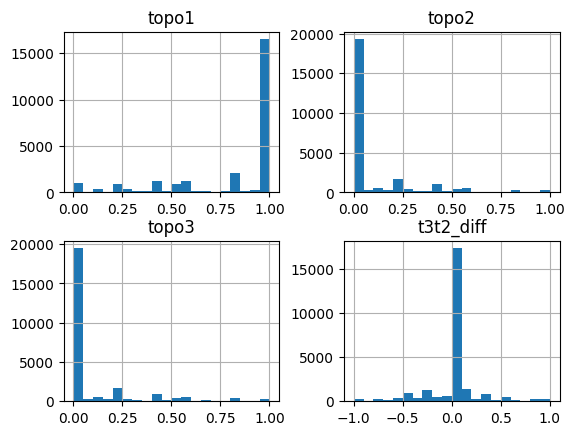

In [23]:
combined_df[["topo1", "topo2", "topo3", "t3t2_diff"]][combined_df["trio"]=="laevis_eatonii_barbatus"].hist(bins=20);

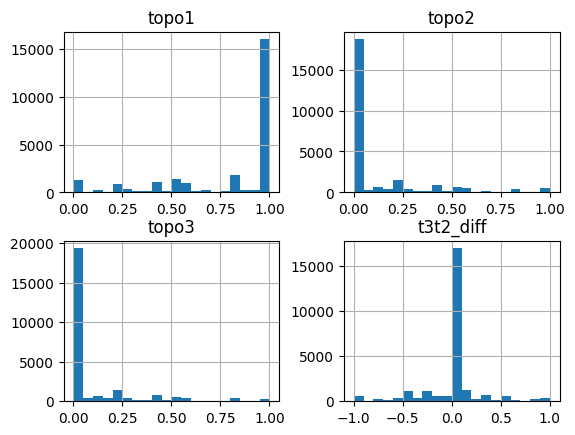

In [24]:
combined_df[["topo1", "topo2", "topo3", "t3t2_diff"]][combined_df["trio"]=="virgatus_barbatus_eatonii"].hist(bins=20);

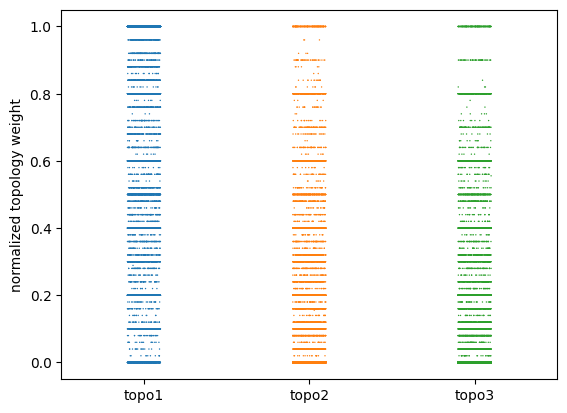

In [25]:
sns.stripplot(combined_df[["topo1", "topo2", "topo3"]][combined_df["trio"]=="laevis_eatonii_barbatus"], s=1, alpha=1)
plt.ylabel("normalized topology weight"); 

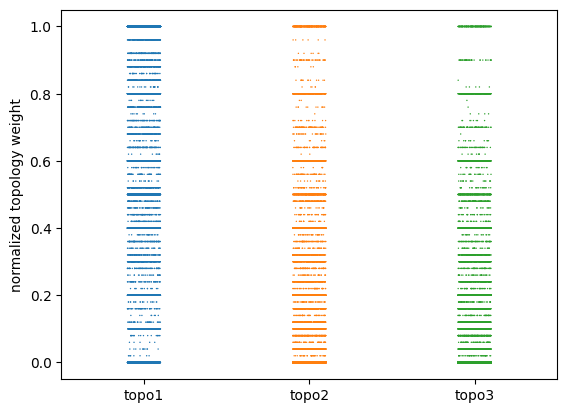

In [26]:
sns.stripplot(combined_df[["topo1", "topo2", "topo3"]][combined_df["trio"]=="virgatus_barbatus_eatonii"], s=1, alpha=1)
plt.ylabel("normalized topology weight"); 

#### Get the extreme peaks with high topo3 weights and find overlap between the two tests

In [27]:
#topo3_cutoff = 0.65 #mean plus two standard deviations for topo3 weighting
#t3t2diff_cutoff = 0.65 #mean plus two standard deviations for topo3 weighting

topo3_cutoff = 0.41 #mean plus 1 standard deviations for topo3 weighting
t3t2diff_cutoff = 0.33 #mean plus 1 standard deviations for topo3 weighting

In [28]:
laevis_eatonii_barbatus_peaks = combined_df[(combined_df["trio"]=="laevis_eatonii_barbatus") & (combined_df["topo3"]==1.0)]
#laevis_eatonii_barbatus_peaks = combined_df[(combined_df["trio"]=="laevis_eatonii_barbatus") & (combined_df["t3t2_diff"]>=cutoff)]
#laevis_eatonii_barbatus_peaks = combined_df[(combined_df["trio"]=="laevis_eatonii_barbatus") & (combined_df["topo3"]>=topo3_cutoff) & (combined_df["t3t2_diff"]>=t3t2diff_cutoff)]

laevis_eatonii_barbatus_peaks

,topo1,topo2,topo3,window_id,chromosome,start,end,trio,tree_no,t3t2_diff
136,0.0,0.0,1.0,LG01_bp_11360001-11370000.fa.tree,LG01,11360001,11370000,laevis_eatonii_barbatus,136,1.0
144,0.0,0.0,1.0,LG01_bp_11430001-11440000.fa.tree,LG01,11430001,11440000,laevis_eatonii_barbatus,144,1.0
152,0.0,0.0,1.0,LG01_bp_1150001-1160000.fa.tree,LG01,1150001,1160000,laevis_eatonii_barbatus,152,1.0
703,0.0,0.0,1.0,LG01_bp_18580001-18590000.fa.tree,LG01,18580001,18590000,laevis_eatonii_barbatus,703,1.0
714,0.0,0.0,1.0,LG01_bp_18770001-18780000.fa.tree,LG01,18770001,18780000,laevis_eatonii_barbatus,714,1.0
...,...,...,...,...,...,...,...,...,...,...
25574,0.0,0.0,1.0,LG08_bp_9140001-9150000.fa.tree,LG08,9140001,9150000,laevis_eatonii_barbatus,25574,1.0
25587,0.0,0.0,1.0,LG08_bp_91540001-91550000.fa.tree,LG08,91540001,91550000,laevis_eatonii_barbatus,25587,1.0
25639,0.0,0.0,1.0,LG08_bp_92070001-92080000.fa.tree,LG08,92070001,92080000,laevis_eatonii_barbatus,25639,1.0
25640,0.0,0.0,1.0,LG08_bp_92080001-92090000.fa.tree,LG08,92080001,92090000,laevis_eatonii_barbatus,25640,1.0


In [29]:
virgatus_barbatus_eatonii_peaks = combined_df[(combined_df["trio"]=="virgatus_barbatus_eatonii") & (combined_df["topo3"]==1.0)]
#virgatus_barbatus_eatonii_peaks = combined_df[(combined_df["trio"]=="virgatus_barbatus_eatonii") & (combined_df["t3t2_diff"]>=cutoff)]
#virgatus_barbatus_eatonii_peaks = combined_df[(combined_df["trio"]=="virgatus_barbatus_eatonii") & (combined_df["topo3"]>=cutoff) & (combined_df["t3t2_diff"]>=t3t2diff_cutoff)]

virgatus_barbatus_eatonii_peaks

,topo1,topo2,topo3,window_id,chromosome,start,end,trio,tree_no,t3t2_diff
49,0.0,0.0,1.0,LG01_bp_10430001-10440000.fa.tree,LG01,10430001,10440000,virgatus_barbatus_eatonii,49,1.0
66,0.0,0.0,1.0,LG01_bp_1060001-1070000.fa.tree,LG01,1060001,1070000,virgatus_barbatus_eatonii,66,1.0
142,0.0,0.0,1.0,LG01_bp_11410001-11420000.fa.tree,LG01,11410001,11420000,virgatus_barbatus_eatonii,142,1.0
295,0.0,0.0,1.0,LG01_bp_12980001-12990000.fa.tree,LG01,12980001,12990000,virgatus_barbatus_eatonii,295,1.0
343,0.0,0.0,1.0,LG01_bp_13450001-13460000.fa.tree,LG01,13450001,13460000,virgatus_barbatus_eatonii,343,1.0
...,...,...,...,...,...,...,...,...,...,...
25556,0.0,0.0,1.0,LG08_bp_91240001-91250000.fa.tree,LG08,91240001,91250000,virgatus_barbatus_eatonii,25556,1.0
25567,0.0,0.0,1.0,LG08_bp_91340001-91350000.fa.tree,LG08,91340001,91350000,virgatus_barbatus_eatonii,25567,1.0
25617,0.0,0.0,1.0,LG08_bp_91830001-91840000.fa.tree,LG08,91830001,91840000,virgatus_barbatus_eatonii,25617,1.0
25640,0.0,0.0,1.0,LG08_bp_92080001-92090000.fa.tree,LG08,92080001,92090000,virgatus_barbatus_eatonii,25640,1.0


In [30]:
overlap = list(set(virgatus_barbatus_eatonii_peaks.index).intersection(set(laevis_eatonii_barbatus_peaks.index)))

In [31]:
# Sanity check the index-based approach to overlap by directly looking at window id overlap
set(virgatus_barbatus_eatonii_peaks.window_id).intersection(set(laevis_eatonii_barbatus_peaks.window_id))

{'LG06_bp_10830001-10840000.fa.tree',
 'LG07_bp_103300001-103310000.fa.tree',
 'LG07_bp_11930001-11940000.fa.tree',
 'LG08_bp_84580001-84590000.fa.tree',
 'LG08_bp_92080001-92090000.fa.tree'}

In [32]:
overlap_peaks = virgatus_barbatus_eatonii_peaks.loc[overlap]
print(len(overlap_peaks))
overlap_peaks

5


,topo1,topo2,topo3,window_id,chromosome,start,end,trio,tree_no,t3t2_diff
24897,0.0,0.0,1.0,LG08_bp_84580001-84590000.fa.tree,LG08,84580001,84590000,virgatus_barbatus_eatonii,24897,1.0
25640,0.0,0.0,1.0,LG08_bp_92080001-92090000.fa.tree,LG08,92080001,92090000,virgatus_barbatus_eatonii,25640,1.0
15955,0.0,0.0,1.0,LG06_bp_10830001-10840000.fa.tree,LG06,10830001,10840000,virgatus_barbatus_eatonii,15955,1.0
18677,0.0,0.0,1.0,LG07_bp_103300001-103310000.fa.tree,LG07,103300001,103310000,virgatus_barbatus_eatonii,18677,1.0
18970,0.0,0.0,1.0,LG07_bp_11930001-11940000.fa.tree,LG07,11930001,11940000,virgatus_barbatus_eatonii,18970,1.0


In [33]:
overlap_peaks.to_csv("overlap-peaks-eatonii-barbatus.csv", sep=",")

In [34]:
with open("overlap-peaks-gene-id.txt", "w") as fout:
    for entry in list(overlap_peaks.window_id):
        fout.write(entry + "\n")

#### Get the coordinates for the significant overlap peaks from the CDS analysis for comparison

In [35]:
peaks_annot = pd.read_csv("/home/lcwheeler/Documents/WessingerLabPostdoc/research/Habroanthus/twisst_analyses/CDS_target_trios/peaks-genes-annotations-eatonii-barbatus.gff", 
                          sep="\t", header=None)

In [36]:
peaks_annot["pos"] = np.round((peaks_annot[3] + peaks_annot[4])/2)

In [37]:
gid = []
for entry in peaks_annot[8]:
    m = entry.split("ID=")[1].split(";")[0].split(":")[0]
    gid.append(m)

In [38]:
peaks_annot["gene_id"] = gid

In [39]:
peaks_annot = peaks_annot[peaks_annot[2] == "CDS"]

In [40]:
peaks_annot.index = peaks_annot.gene_id

In [41]:
# Drop duplicate indexes from the overlap peaks dataframe
peaks_annot = peaks_annot[~peaks_annot.index.duplicated(keep='first')]

In [42]:
peaks_annot.to_csv("/home/lcwheeler/Documents/WessingerLabPostdoc/research/Habroanthus/twisst_analyses/CDS_target_trios/peaks-genes-annotations-eatonii-barbatus-dedup.csv", sep=",")

In [43]:
peaks_annot = peaks_annot.drop([1, 5, 6, 7, 8], axis=1)
peaks_annot.columns = ["Chromosome", "Type", "Start", "End", "Pos", "Gene_id"]

In [44]:
peaks_annot

,Chromosome,Type,Start,End,Pos,Gene_id
gene_id,,,,,,
Pbar_2022_maker4_06095-RA,LG08,CDS,80345501,80345650,80345576.0,Pbar_2022_maker4_06095-RA
Pbar_2022_maker4_06721-RA,LG08,CDS,86021908,86022091,86022000.0,Pbar_2022_maker4_06721-RA
Pbar_2022_maker4_07525-RA,LG08,CDS,92229127,92229154,92229140.0,Pbar_2022_maker4_07525-RA
Pbar_2022_maker4_22926-RA,LG06,CDS,39783494,39783721,39783608.0,Pbar_2022_maker4_22926-RA
Pbar_2022_maker4_23816-RA,LG06,CDS,48602196,48602236,48602216.0,Pbar_2022_maker4_23816-RA
Pbar_2022_maker4_00460-RA,LG07,CDS,3836212,3836437,3836324.0,Pbar_2022_maker4_00460-RA
Pbar_2022_maker4_01435-RD,LG07,CDS,12573384,12573677,12573530.0,Pbar_2022_maker4_01435-RD
Pbar_2022_maker4_20228-RA,LG05,CDS,17230671,17230998,17230834.0,Pbar_2022_maker4_20228-RA
Pbar_2022_maker4_15330-RA,LG04,CDS,5095488,5095779,5095634.0,Pbar_2022_maker4_15330-RA


In [45]:
overlap_peaks.columns = ['topo1', 'topo2', 'topo3', 'window_id', 'Chromosome', 'Start', 'End', 'trio', 'tree_no', 't3t2_diff']
overlap_peaks

,topo1,topo2,topo3,window_id,Chromosome,Start,End,trio,tree_no,t3t2_diff
24897,0.0,0.0,1.0,LG08_bp_84580001-84590000.fa.tree,LG08,84580001,84590000,virgatus_barbatus_eatonii,24897,1.0
25640,0.0,0.0,1.0,LG08_bp_92080001-92090000.fa.tree,LG08,92080001,92090000,virgatus_barbatus_eatonii,25640,1.0
15955,0.0,0.0,1.0,LG06_bp_10830001-10840000.fa.tree,LG06,10830001,10840000,virgatus_barbatus_eatonii,15955,1.0
18677,0.0,0.0,1.0,LG07_bp_103300001-103310000.fa.tree,LG07,103300001,103310000,virgatus_barbatus_eatonii,18677,1.0
18970,0.0,0.0,1.0,LG07_bp_11930001-11940000.fa.tree,LG07,11930001,11940000,virgatus_barbatus_eatonii,18970,1.0


In [46]:
gr1 = pr.PyRanges(overlap_peaks)
gr2 = pr.PyRanges(peaks_annot)

In [47]:
cds_df_overlap = gr1.intersect(gr2, how=None)
cds_df_overlap

""


##### Confirm the overlap result for Twisst CDS and Twisst genomic windows manually

In [48]:
peaks_annot[peaks_annot["Chromosome"] == "LG06"]

,Chromosome,Type,Start,End,Pos,Gene_id
gene_id,,,,,,
Pbar_2022_maker4_22926-RA,LG06,CDS,39783494,39783721,39783608.0,Pbar_2022_maker4_22926-RA
Pbar_2022_maker4_23816-RA,LG06,CDS,48602196,48602236,48602216.0,Pbar_2022_maker4_23816-RA


In [49]:
overlap_peaks[overlap_peaks["Chromosome"] == "LG06"]

,topo1,topo2,topo3,window_id,Chromosome,Start,End,trio,tree_no,t3t2_diff
15955,0.0,0.0,1.0,LG06_bp_10830001-10840000.fa.tree,LG06,10830001,10840000,virgatus_barbatus_eatonii,15955,1.0


In [50]:
peaks_annot[peaks_annot["Chromosome"] == "LG07"]

,Chromosome,Type,Start,End,Pos,Gene_id
gene_id,,,,,,
Pbar_2022_maker4_00460-RA,LG07,CDS,3836212,3836437,3836324.0,Pbar_2022_maker4_00460-RA
Pbar_2022_maker4_01435-RD,LG07,CDS,12573384,12573677,12573530.0,Pbar_2022_maker4_01435-RD


In [51]:
overlap_peaks[overlap_peaks["Chromosome"] == "LG07"]

,topo1,topo2,topo3,window_id,Chromosome,Start,End,trio,tree_no,t3t2_diff
18677,0.0,0.0,1.0,LG07_bp_103300001-103310000.fa.tree,LG07,103300001,103310000,virgatus_barbatus_eatonii,18677,1.0
18970,0.0,0.0,1.0,LG07_bp_11930001-11940000.fa.tree,LG07,11930001,11940000,virgatus_barbatus_eatonii,18970,1.0


In [52]:
peaks_annot[peaks_annot["Chromosome"] == "LG08"]

,Chromosome,Type,Start,End,Pos,Gene_id
gene_id,,,,,,
Pbar_2022_maker4_06095-RA,LG08,CDS,80345501,80345650,80345576.0,Pbar_2022_maker4_06095-RA
Pbar_2022_maker4_06721-RA,LG08,CDS,86021908,86022091,86022000.0,Pbar_2022_maker4_06721-RA
Pbar_2022_maker4_07525-RA,LG08,CDS,92229127,92229154,92229140.0,Pbar_2022_maker4_07525-RA


In [53]:
overlap_peaks[overlap_peaks["Chromosome"] == "LG08"]

,topo1,topo2,topo3,window_id,Chromosome,Start,End,trio,tree_no,t3t2_diff
24897,0.0,0.0,1.0,LG08_bp_84580001-84590000.fa.tree,LG08,84580001,84590000,virgatus_barbatus_eatonii,24897,1.0
25640,0.0,0.0,1.0,LG08_bp_92080001-92090000.fa.tree,LG08,92080001,92090000,virgatus_barbatus_eatonii,25640,1.0
